In [1]:
import torch
from torch import nn

print(torch.__version__)
import numpy as np
import math

2.7.1+cu126


In [9]:
import sys
sys.path.append("/home/s0001666/Working_dir/my_repos/GPT_my/enc_dec_impl/src/")


In [10]:
from transformers import AutoTokenizer

In [11]:
from enc_dec_impl.src.data.dataloader import MyGPTDataset, gpt_collate_fn
from enc_dec_impl.src.transformer import Transformer

In [12]:
from enc_dec_impl.src.trainer import TransLoss, train_step, eval_step

In [13]:
batch_size = 64

## Data

In [14]:
from datasets import load_dataset

# loads train/validation/test splits with fields "en" and "de"
data = load_dataset("bentrevett/multi30k")
train, valid, test = data["train"], data["validation"], data["test"]

# peek at one example
print(train[0])


{'en': 'Two young, White males are outside near many bushes.', 'de': 'Zwei junge weiße Männer sind im Freien in der Nähe vieler Büsche.'}


In [15]:
len(train), len(valid), len(test)

(29000, 1014, 1000)

In [16]:
gpt_dataset = MyGPTDataset(train)
gpt_dataset_eval = MyGPTDataset(valid)

gpt_dataloader = torch.utils.data.DataLoader(dataset=gpt_dataset, 
                                             collate_fn=gpt_collate_fn, 
                                             shuffle=True, 
                                             batch_size=batch_size)

gpt_dataloader_eval = torch.utils.data.DataLoader(dataset=gpt_dataset_eval, 
                                                  collate_fn=gpt_collate_fn, 
                                                  shuffle=False, 
                                                  batch_size=batch_size)

In [17]:
batch = next(iter(gpt_dataloader))

In [18]:
batch 

(tensor([[  246,  4157, 28246,  ..., 58100, 58100, 58100],
         [  246,   149,   526,  ..., 58100, 58100, 58100],
         [  525,  1614,   409,  ..., 58100, 58100, 58100],
         ...,
         [  246, 19043,    45,  ..., 58100, 58100, 58100],
         [ 1764,    81,    50,  ..., 58100, 58100, 58100],
         [  246, 27881,    45,  ..., 58100, 58100, 58100]]),
 tensor([[58100,    93, 16889,  ..., 58100, 58100, 58100],
         [58100,    93, 42378,  ..., 58100, 58100, 58100],
         [58100,    93,   847,  ..., 58100, 58100, 58100],
         ...,
         [58100,    93, 12570,  ..., 58100, 58100, 58100],
         [58100,  4106, 19129,  ..., 58100, 58100, 58100],
         [58100,    93,    52,  ..., 58100, 58100, 58100]]))

In [19]:
src_ids, tgt_ids = batch
tgt_ids

tensor([[58100,    93, 16889,  ..., 58100, 58100, 58100],
        [58100,    93, 42378,  ..., 58100, 58100, 58100],
        [58100,    93,   847,  ..., 58100, 58100, 58100],
        ...,
        [58100,    93, 12570,  ..., 58100, 58100, 58100],
        [58100,  4106, 19129,  ..., 58100, 58100, 58100],
        [58100,    93,    52,  ..., 58100, 58100, 58100]])

In [20]:


# for de→en
tokenizer_de_en = AutoTokenizer.from_pretrained("Helsinki-NLP/opus-mt-de-en")

In [21]:
de_tokens = tokenizer_de_en(
        train[0]['de'], return_tensors="pt", padding=True, truncation=True
    )

In [22]:
len(tokenizer_de_en)

58101

### Train

In [23]:
# hyperparameters 
emb_dim = 256
feature_dim = 256
n_encoders = 4
n_decoders = 4
tgt_vocab_size = len(tokenizer_de_en)
src_vocab_size = len(tokenizer_de_en)
padding_idx = tokenizer_de_en.pad_token_id
max_len = 128
num_epochs = 30 
log_every = int(len(gpt_dataloader) / 10)
gen_every = 1
gen_k = 3
attn_dropout = 0.25
ffn_dropout = 0.25
n_heads = 8

In [24]:
model = Transformer(
    emb_dim=emb_dim,
    feature_dim=feature_dim,
    n_encoders=n_encoders,
    n_decoders=n_decoders,
    tgt_vocab_size=tgt_vocab_size,
    src_vocab_size=src_vocab_size,
    max_len=max_len,
    n_heads=n_heads,
    padding_idx=padding_idx,
    attn_dropout=attn_dropout,
    ffn_dropout=ffn_dropout,               
).cuda()

In [25]:
len(gpt_dataloader)

454

In [26]:

loss_fn = TransLoss(label_smoothing=0.1)
optim = torch.optim.Adam(
    model.parameters(),
    lr=.5,                
    betas=(0.9, 0.98),
    eps=1e-9,
)



In [27]:
d_model = emb_dim
warmup_steps = 1000

def noam_lr(step: int):
    step = max(step, 1)
    return (d_model ** -0.5) * min(step ** -0.5, step * (warmup_steps ** -1.5))

In [28]:
scheduler = torch.optim.lr_scheduler.LambdaLR(
    optim, lr_lambda=lambda step: noam_lr(step)
)

In [30]:
from collections import OrderedDict

def count_params(p_iter):
    return sum(p.numel() for p in p_iter)

def group_param_counts(model):
    """
    Groups params by Transformer blocks (encoder/decoder FFN/attn/norms + embeddings/head/PE).
    Adjust rules if your attribute names differ.
    """
    rules = OrderedDict({
        # top-level
        "embeddings/source":      {"all": ["source_embedding"]},
        "embeddings/target":      {"all": ["target_embedding"]},
        "positional_encoding":    {"all": ["PE."]},          # buffer-only usually => 0 trainable
        "lm_head":                {"all": ["lm_head"]},

        # encoder
        "encoder/attn":           {"all": ["encoder."], "any": [".mha."]},
        "encoder/ffn":            {"all": ["encoder."], "any": [".ffn."]},
        "encoder/norms":          {"all": ["encoder."], "any": ["norm"]},

        # decoder
        "decoder/self_attn":      {"all": ["decoder."], "any": [".sa."]},
        "decoder/cross_attn":     {"all": ["decoder."], "any": [".ca."]},
        "decoder/ffn":            {"all": ["decoder."], "any": [".ffn."]},
        "decoder/norms":          {"all": ["decoder."], "any": ["norm"]},
    })

    # init buckets
    buckets = OrderedDict((k, {"total": 0, "trainable": 0}) for k in rules.keys())
    buckets["other"] = {"total": 0, "trainable": 0}

    def match(name, rule):
        if "all" in rule and not all(s in name for s in rule["all"]):
            return False
        if "any" in rule and not any(s in name for s in rule["any"]):
            return False
        return True

    for name, p in model.named_parameters():
        placed = False
        for gname, rule in rules.items():
            if match(name, rule):
                buckets[gname]["total"] += p.numel()
                if p.requires_grad:
                    buckets[gname]["trainable"] += p.numel()
                placed = True
                break
        if not placed:
            buckets["other"]["total"] += p.numel()
            if p.requires_grad:
                buckets["other"]["trainable"] += p.numel()

    return buckets

# ---- usage ----
buckets = group_param_counts(model)
for k, v in buckets.items():
    print(f"{k:22s} total={v['total']:,}  trainable={v['trainable']:,}")

print("\nGrand total:", sum(v["total"] for v in buckets.values()))


embeddings/source      total=14,873,856  trainable=14,873,856
embeddings/target      total=14,873,856  trainable=14,873,856
positional_encoding    total=0  trainable=0
lm_head                total=14,931,957  trainable=14,931,957
encoder/attn           total=1,052,672  trainable=1,052,672
encoder/ffn            total=2,102,272  trainable=2,102,272
encoder/norms          total=4,096  trainable=4,096
decoder/self_attn      total=1,052,672  trainable=1,052,672
decoder/cross_attn     total=1,052,672  trainable=1,052,672
decoder/ffn            total=2,102,272  trainable=2,102,272
decoder/norms          total=8,192  trainable=8,192
other                  total=0  trainable=0

Grand total: 52054517


In [22]:
# # overfit 
# for _ in range(50):
#     l = train_step(model, batch, optim, loss_fn, pad_id=padding_idx)
#     print(l)

In [23]:
bos_token_id = tokenizer_de_en.pad_token_id
bos_token_id

58100

In [24]:
eos_token_id = tokenizer_de_en.eos_token_id
eos_token_id

0

In [25]:
global_step = 0
t_losses = []
v_losses = []
for epoch in range(1, num_epochs + 1):
    # ---- train ----
    running = 0.0
    n = 0
    for step, batch in enumerate(gpt_dataloader, start=1):
        global_step += 1
        loss = train_step(model, batch, optim, loss_fn, padding_idx, scheduler)
        running += loss
        n += 1

        if step % log_every == 0:
            print(f"epoch {epoch} step {step} | train_loss {running/n:.4f} | lr {optim.param_groups[0]['lr']:.7f}")

    train_loss = running / max(n, 1)
    t_losses.append(train_loss)
    
    # ---- valid ----
    val_sum = 0.0
    m = 0
    for batch in gpt_dataloader_eval:
        val_sum += eval_step(model, batch, loss_fn, padding_idx)
        m += 1
    val_loss = val_sum / max(m, 1)
    v_losses.append(val_loss)
    print(f"\nEPOCH {epoch} DONE | train_loss {train_loss:.4f} | val_loss {val_loss:.4f}\n")

    # ---- sample generation ----
    if (tokenizer_de_en is not None) and (epoch % gen_every == 0):
        model.eval()
        src_ids, tgt_ids = next(iter(gpt_dataloader_eval))
        src_ids = src_ids[:gen_k].to('cuda')
        tgt_ids = tgt_ids[:gen_k]

        pred_ids = model.generate(src_ids, bos_token=bos_token_id, eos_token=eos_token_id, strategy="beam")

        for i in range(min(gen_k, src_ids.size(0))):
            src_txt = tokenizer_de_en.decode(src_ids[i].detach().cpu(), skip_special_tokens=False)
            tgt_txt = tokenizer_de_en.decode(tgt_ids[i].detach().cpu(), skip_special_tokens=False)
            pred_txt = tokenizer_de_en.decode(pred_ids[i].detach().cpu(), skip_special_tokens=False)
            print(f"[sample {i}] SRC : {src_txt}")
            print(f"[sample {i}] TGT : {tgt_txt}")
            print(f"[sample {i}] PRED: {pred_txt}")
            print()
    

epoch 1 step 45 | train_loss 37.0294 | lr 0.0000445
epoch 1 step 90 | train_loss 32.8435 | lr 0.0000889
epoch 1 step 135 | train_loss 28.7333 | lr 0.0001334
epoch 1 step 180 | train_loss 25.5302 | lr 0.0001779
epoch 1 step 225 | train_loss 23.0528 | lr 0.0002223
epoch 1 step 270 | train_loss 21.1267 | lr 0.0002668
epoch 1 step 315 | train_loss 19.5452 | lr 0.0003113
epoch 1 step 360 | train_loss 18.2546 | lr 0.0003558
epoch 1 step 405 | train_loss 17.1684 | lr 0.0004002
epoch 1 step 450 | train_loss 16.2281 | lr 0.0004447

EPOCH 1 DONE | train_loss 16.1542 | val_loss 7.3366

[sample 0] SRC : Eine Gruppe von Männern lädt Baumwolle auf einen Lastwagen</s> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
[sample 0] TGT : <pad> A group of men are loading cotton onto a truck</s> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
[sampl

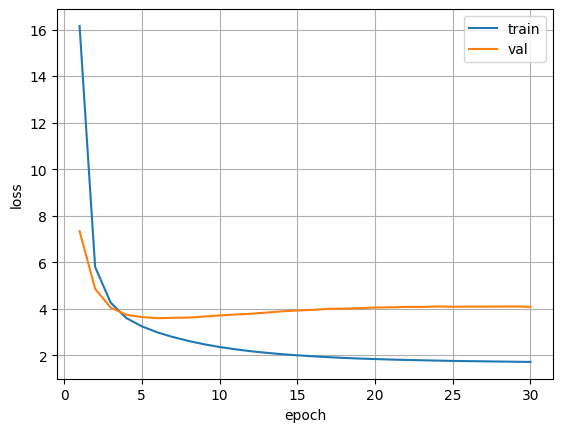

In [26]:
import matplotlib.pyplot as plt

assert len(t_losses) == len(v_losses), "t_losses and v_losses must have same length"
epochs = list(range(1, len(t_losses) + 1))

plt.figure()
plt.plot(epochs, t_losses, label="train")
plt.plot(epochs, v_losses, label="val")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.grid(True)
plt.show()


### Test

In [25]:
batch

(tensor([[ 3303,  2843,    74,  ..., 58100, 58100, 58100],
         [  246,  7766, 10570,  ..., 58100, 58100, 58100],
         [ 3303, 26997,  3816,  ...,     0, 58100, 58100],
         ...,
         [  525, 15653,   810,  ..., 58100, 58100, 58100],
         [ 3303,  2843,  1141,  ..., 58100, 58100, 58100],
         [ 3303,  1075,     5,  ..., 58100, 58100, 58100]]),
 tensor([[58100,  4386,  1135,  ..., 58100, 58100, 58100],
         [58100,    93,  7543,  ..., 58100, 58100, 58100],
         [58100,  4386,  6762,  ..., 58100, 58100, 58100],
         ...,
         [58100,    93, 17525,  ..., 58100, 58100, 58100],
         [58100,  4386,  1135,  ..., 58100, 58100, 58100],
         [58100,  4386,  1190,  ..., 58100, 58100, 58100]]))

In [20]:
test_id = 0
src_id = 0
tgt_id = 1

0

58100

In [23]:
src_ids = batch[src_id].cuda()
src_ids, src_ids.view(2, -1).shape

(tensor([[ 5029,   654,    17,  4839,   749,    63,    37,   117,  3688, 46732,
              3,     0, 58100, 58100, 58100, 58100],
         [  525,   788,    30,    94, 11671,    15, 10728, 29361,    17, 29016,
             46,     5,   117,  4054,     3,     0]], device='cuda:0'),
 torch.Size([2, 16]))

In [24]:
for i in range(len(src_ids)):
    print(tokenizer_de_en.decode(src_ids[i].detach().cpu()))
    print()

Drei Kinder balgen sich auf einem Blumenteppich.</s> <pad> <pad> <pad> <pad>

Eine Frau mit einer gelben Badekappe schwimmt in einem Pool.</s>



In [25]:
tgt_ids = batch[tgt_id]
tgt_ids

tensor([[58100,  7871,   734,  3066,  6731,   442,    32,    14, 35540, 22649,
             3,     0, 58100, 58100, 58100],
        [58100,    93,  6762,     5,    14,  8746, 18769,  7261,    19,  5638,
             5,    14,  2283,     3,     0]])

In [26]:
for i in range(len(tgt_ids)):
    print(tokenizer_de_en.decode(tgt_ids[i]))
    print()

<pad> Three children wrestle on a floral carpet.</s> <pad> <pad> <pad>

<pad> A female in a yellow swim cap is swimming in a pool.</s>



In [27]:
answer = model.generate(src_ids=src_ids.view(2, -1), bos_token=bos_token_id, eos_token=eos_token_id)

print(answer)


tensor([[7871],
        [  93]], device='cuda:0')
tensor([[False],
        [False]], device='cuda:0')
tensor([[ 734],
        [6762]], device='cuda:0')
tensor([[False],
        [False]], device='cuda:0')
tensor([[3066],
        [   5]], device='cuda:0')
tensor([[False],
        [False]], device='cuda:0')
tensor([[6731],
        [  14]], device='cuda:0')
tensor([[False],
        [False]], device='cuda:0')
tensor([[ 442],
        [8746]], device='cuda:0')
tensor([[False],
        [False]], device='cuda:0')
tensor([[   32],
        [18769]], device='cuda:0')
tensor([[False],
        [False]], device='cuda:0')
tensor([[  14],
        [7261]], device='cuda:0')
tensor([[False],
        [False]], device='cuda:0')
tensor([[35540],
        [   19]], device='cuda:0')
tensor([[False],
        [False]], device='cuda:0')
tensor([[22649],
        [ 5638]], device='cuda:0')
tensor([[False],
        [False]], device='cuda:0')
tensor([[3],
        [5]], device='cuda:0')
tensor([[False],
        [False]

In [28]:
tgt_ids

tensor([[58100,  7871,   734,  3066,  6731,   442,    32,    14, 35540, 22649,
             3,     0, 58100, 58100, 58100],
        [58100,    93,  6762,     5,    14,  8746, 18769,  7261,    19,  5638,
             5,    14,  2283,     3,     0]])

In [29]:
for i in range(len(answer)):
    print(tokenizer_de_en.decode(answer[i].detach().cpu()))
    print()

<pad> Three children wrestle on a floral carpet.</s> </s> </s> </s>

<pad> A female in a yellow swim cap is swimming in a pool.</s>



In [30]:
for i in range(len(tgt_ids)):
    print(tokenizer_de_en.decode(tgt_ids[i]))
    print()

<pad> Three children wrestle on a floral carpet.</s> <pad> <pad> <pad>

<pad> A female in a yellow swim cap is swimming in a pool.</s>



In [31]:
import math
import torch
import torch.nn.functional as F

@torch.no_grad()
def _encode_memory(model, src_ids_1xS):
    # src_ids_1xS: [1, S] (Long)
    S = src_ids_1xS.size(1)
    src_emb = math.sqrt(model.emb_dim) * model.source_embedding(src_ids_1xS)
    src_emb = src_emb + model.PE.get(S, device=src_emb.device, dtype=src_emb.dtype)
    memory = model.encoder(src_emb, None)   # [1, S, D]
    return memory

@torch.no_grad()
def _next_logits_given_prefix(model, memory_1xSxD, prefix_ids_1xT):
    # prefix_ids_1xT: [1, T] (Long), includes BOS as first token
    T = prefix_ids_1xT.size(1)
    tgt_emb = math.sqrt(model.emb_dim) * model.target_embedding(prefix_ids_1xT)
    tgt_emb = tgt_emb + model.PE.get(T, device=tgt_emb.device, dtype=tgt_emb.dtype)

    hidden = model.decoder(tgt_emb, memory_1xSxD, attn_mask=None)  # [1, T, D]
    h_last = hidden[:, -1, :]                                      # [1, D]
    logits = model.lm_head(h_last)                                 # [1, V]
    return logits

def test_cross_attention_effect(model, tokenizer, src_a, src_b, prefix_ids, topk=10):
    """
    If encoder memory matters, logits(prefix, mem_a) and logits(prefix, mem_b) should differ.
    """
    device = next(model.parameters()).device
    model.eval()

    src_a = src_a.to(device).view(1, -1).long()
    src_b = src_b.to(device).view(1, -1).long()
    prefix_ids = prefix_ids.to(device).view(1, -1).long()  # include BOS at pos0

    with torch.no_grad():
        mem_a = _encode_memory(model, src_a)
        mem_b = _encode_memory(model, src_b)

        logits_a = _next_logits_given_prefix(model, mem_a, prefix_ids)
        logits_b = _next_logits_given_prefix(model, mem_b, prefix_ids)

        diff = (logits_a - logits_b).abs()
        print("prefix_len:", prefix_ids.size(1))
        print("max |Δlogit|:", diff.max().item())
        print("mean|Δlogit|:", diff.mean().item())
        print("cosine(logits_a, logits_b):", F.cosine_similarity(logits_a, logits_b, dim=-1).item())

        top_a = torch.topk(logits_a[0], topk).indices.tolist()
        top_b = torch.topk(logits_b[0], topk).indices.tolist()

        print("\nTop A:", [(i, tokenizer.decode([i])) for i in top_a[:10]])
        print("Top B:", [(i, tokenizer.decode([i])) for i in top_b[:10]])

        # also show whether top-1 differs
        a1 = top_a[0]
        b1 = top_b[0]
        print("\nTop-1 A:", a1, tokenizer.decode([a1]))
        print("Top-1 B:", b1, tokenizer.decode([b1]))

        return logits_a, logits_b


In [32]:
src_ids_batch, tgt_ids_batch = batch  # from your dataloader (after BOS prepend)
src0 = src_ids_batch[0].cuda()
src1 = src_ids_batch[1].cuda()

# use the SAME prefix for both sources; take first K tokens from tgt0 (already includes BOS)
K = 18
prefix = tgt_ids_batch[1, :K].cuda()

logits_a, logits_b = test_cross_attention_effect(model, tokenizer_de_en, src0, src1, prefix)


prefix_len: 15
max |Δlogit|: 13.203795433044434
mean|Δlogit|: 2.046481132507324
cosine(logits_a, logits_b): 0.9296603202819824


2026-01-14 15:35:21.377769: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-01-14 15:35:21.406302: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2026-01-14 15:35:21.406333: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2026-01-14 15:35:21.406367: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2026-01-14 15:35:21.412358: I tensorflow/core/platform/cpu_feature_g

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

2026-01-14 15:35:22.086068: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'


Top A: [(26264, 'LAR'), (734, 'children'), (49901, '头'), (28495, 'Training'), (38846, 'ganzjährig'), (49122, 'ŝ'), (5029, 'Drei'), (50475, 'տ'), (37958, 'zuwachs'), (23118, 'verlor')]
Top B: [(26264, 'LAR'), (38599, 'gestaltet'), (25553, 'FREE'), (28495, 'Training'), (26377, 'Bereit'), (42988, 'duktiv'), (23118, 'verlor'), (49901, '头'), (5029, 'Drei'), (37958, 'zuwachs')]

Top-1 A: 26264 LAR
Top-1 B: 26264 LAR


In [33]:
from transformers import AutoTokenizer

# for de→en
tokenizer_de_en = AutoTokenizer.from_pretrained("Helsinki-NLP/opus-mt-de-en")

In [34]:
en_text = 'Test English text'

In [35]:
tokens = tokenizer_de_en("Ein Mann fährt Fahrrad.", return_tensors="pt", padding=True)
input_ids = tokens.input_ids  # ⟦batch, seq_len⟧

In [36]:
en_tokens = tokenizer_de_en(text_target=en_text, return_tensors="pt", padding=True)

In [37]:
en_tokens

{'input_ids': tensor([[2416,  689, 2183,    0]]), 'attention_mask': tensor([[1, 1, 1, 1]])}

In [38]:
input_ids

tensor([[  246,  1155, 15646,  7766,     3,     0]])

In [39]:
vocab_size = len(tokenizer_de_en)

print(f"Vocab size: {vocab_size}")

Vocab size: 58101


## Attention Blocks

In [40]:
L = 10
S = 10
import torch 
import numpy as np
attn_mask = torch.Tensor(np.zeros((S, L)))
for i in range(S):
    for j in range(L):
        if i<=j:
            attn_mask[i][j] = 1
# attn_mask[idx] = 1
attn_mask

tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [0., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [0., 0., 1., 1., 1., 1., 1., 1., 1., 1.],
        [0., 0., 0., 1., 1., 1., 1., 1., 1., 1.],
        [0., 0., 0., 0., 1., 1., 1., 1., 1., 1.],
        [0., 0., 0., 0., 0., 1., 1., 1., 1., 1.],
        [0., 0., 0., 0., 0., 0., 1., 1., 1., 1.],
        [0., 0., 0., 0., 0., 0., 0., 1., 1., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])

### MHA

In [41]:
class MultiHeadAttention(nn.Module):
    def __init__(self, input_dim, feature_dim, n_heads=4):
        super().__init__()
        self.n_heads = n_heads
        self.q_projection = nn.Linear(input_dim, feature_dim)
        self.k_projection = nn.Linear(input_dim, feature_dim)
        self.v_projection = nn.Linear(input_dim, feature_dim)

        
    def forward(self, input, data, mask=None):
        # project
        Q = self.q_projection(input)
        K = self.k_projection(data)
        V = self.v_projection(data)

        B, S, C = Q.shape
        H = self.n_heads
        d = C // H
        # SDPA
        Q = Q.reshape(B, S, H, d).transpose(1, 2)
        K = K.reshape(B, S, H, d).transpose(1, 2)
        V = V.reshape(B, S, H, d).transpose(1, 2)

        print(Q.shape, K.shape, V.shape)

        Z = scaled_dot_product_attention(Q, K, V)
        Z = Z.reshape(B, S, C)

        return Z

In [42]:
model = MultiHeadAttention(128, 128)

In [43]:
tokens = tokenizer_de_en("ich heiße Daniil. Wie heißt du?", return_tensors="pt", padding=True)
input_ids = tokens.input_ids  # ⟦batch, seq_len⟧

In [44]:
input_ids.shape

torch.Size([1, 11])

In [45]:
embedding = torch.nn.Embedding(embedding_dim=128, num_embeddings=58101)

In [46]:
input = embedding(input_ids)
data = embedding(input_ids)
input.shape

torch.Size([1, 11, 128])

In [47]:
out = model(input, data)

torch.Size([1, 4, 11, 32]) torch.Size([1, 4, 11, 32]) torch.Size([1, 4, 11, 32])


NameError: name 'scaled_dot_product_attention' is not defined

In [ ]:
out.shape

## FFN

In [ ]:
class FeedForward(nn.Module):
    def __init__(self, input_dim, hidden_dim, dropout = 0.0):
        super().__init__()
        self.linear1 = nn.Linear(input_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, input_dim)
        self.norm = nn.LayerNorm(input_dim)
        self.drop = nn.Dropout(dropout)
        self.act = nn.GELU()
    
        
    def forward(self, x):
        print(x.shape)
        out = self.linear1(x)
        out = self.act(out)
        print(out.shape)
        out = self.linear2(out)
        out = self.drop(out)
        out = self.norm(out + x)
        return out

### AttentionBlock

In [ ]:

class AttentionBlock(nn.Module):
    def __init__(self, input_dim, feature_dim, n_heads=4, 
                 dropout=0.0):
        
        super().__init__()
        self.mha = MultiHeadAttention(input_dim=input_dim,
                                     feature_dim=feature_dim,
                                     n_heads=n_heads)
        self.Dropout = nn.Dropout(dropout)
        self.ln = nn.LayerNorm(feature_dim)
        
        
    def forward(self, input, data, mask=None):
        out = self.Dropout(self.mha(self.ln(input), data))
        out = input + out
        return out
        

In [ ]:
model = AttentionBlock(128, 128)

In [ ]:
out = model(input, data)

In [ ]:
out.shape

### SA/CA

In [ ]:
class SelfAttention(nn.Module):
    def __init__(self, feature_dim, n_heads=1): 
        super().__init__()
        
        self.attention = Attention(feature_dim)
        
    def forward(self, data):
        return self.attention(data, data)

class CrossAttention(nn.Module):
    def __init__(self, feature_dim, n_heads=1): 
        super().__init__()
        
        self.attention = Attention(feature_dim)
        
    def forward(self, data, latent):
        return self.attention(data, latent)


## Encoder

## Decoder

## Transformer

In [ ]:
class Transformer(nn.Module):
    def __init__():
        super().__init__()
        

In [ ]:
my_model = AttentionBlock(128)

In [ ]:
t = torch.Tensor(np.random.randn(4,4))
print(t)
ans_t = torch.nn.functional.softmax(t, dim=0)

In [ ]:
torch.sum(ans_t[:,0])

In [ ]:
x = torch.Tensor(np.random.randn(4,4,128))
torch.nn.functional.softmax(x).shape

In [ ]:
my_model(x, x)